# Functional Alignment
When performing any type of group analysis, we assume that each voxel is reflecting the same computations across all participants. This assumption is unlikely to be true. Several standard preprocessing steps assist in improving 'anatomical alignment'. We spatially normalize to a common anatomical template and we also apply spatial smoothing to improve signal to noise ratios in a target voxel by averaging activity in surrounding voxels with a gaussian kernel. However, these techniques are limited when learning multivariate models, where voxel alignment across participants is critical to making accurate inference.

There have been several developments in improving 'functional alignment'. Jim Haxby's group has pioneered [hyperalignment](https://academic.oup.com/cercor/article/26/6/2919/1754308), which uses an iterative procrustes transform to scale, rotate, and reflect voxel time series so that they are in the same functional space across participants. They have found that this technique can dramatically improve between subject classification accuracy particularly in [ventral temporal cortex](http://haxbylab.dartmouth.edu/publications/HGC+11.pdf). This technique is implemented in the [PyMVPA](http://www.pymvpa.org) toolbox. Another promising functional alignment technique known as the [Shared Response Model](http://papers.nips.cc/paper/5855-a-reduced-dimension-fmri-shared-response-model.pdf) was developed at Princeton to improve intersubject-connectivity analyses and is implemented in the [brainiak](https://brainiak.org/) toolbox. They also have found that this technique can improve between subject analyses. This method has several additional interesting properties such as the ability to learn a lower dimensional common representational space and also a probabilistic implementation. 

In this tutorial we demonstrate how to perform functional alignment using both hyperalignment and the shared response model using nltools. You can also read this [tutorial](https://brainiak.org/tutorials/11-SRM/) for how to perform SRM using brainiak.


## Load Data
The first thing we need to do in this tutorial is load some data to work with. Let's start by importing the modules we will use for this tutorial.

In [3]:
import os
import glob
import numpy as np
from nltools.mask import create_sphere, expand_mask
from nltools.data import Brain_Data
from nltools.stats import align
import matplotlib.pyplot as plt
from nilearn.plotting import plot_glass_brain

base_dir = '/Users/lukechang/Dropbox/Dartbrains/'
data_dir = '/Volumes/Engram/Data/Old/Sherlock/fmriprep'

Functional alignment is typically performed within an ROI. The original hyperalignment papers align within searchlights over the whole brain. We tend to align within regions of interest from whole-brain functional parcellations. We will use a n=50 [parcellation](http://cosanlab.com/static/papers/delaVega_2016_JNeuro.pdf) based on patterns of coactivation from the Neurosynth database. 

We can load data from a file or web URL using the `Brain_Data` data class from [nltools](https://neurolearn.readthedocs.io/en/latest/auto_examples/01_DataOperations/plot_download.html#sphx-glr-auto-examples-01-dataoperations-plot-download-py).

threshold is ignored for simple axial plots


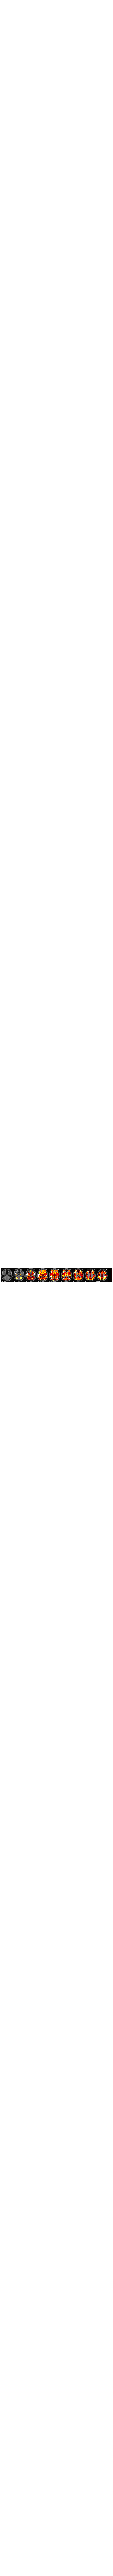

In [38]:
mask = Brain_Data('http://neurovault.org/media/images/2099/Neurosynth%20Parcellation_0.nii.gz')
mask_x = expand_mask(mask)
mask.plot()

First, let's extract data from each subject within a region of interest. In this example, we will extract voxel activity within early visual cortex from the second half of Sherlock (i.e., Part2). Warning loading large nifti files with nltools can be slow. If you commit to this software, we recommend saving your data as an hdf5 container to dramatically speed up reading and writing. Loading the all of the Sherlock data will take ~10-15min.

In [12]:
scan = 'Part2'
roi = 4

roi_mask = mask_x[roi]

file_list = glob.glob(os.path.join(data_dir, '*', 'func', f'*crop*{scan}*nii.gz'))
all_data = {}
for f in file_list:
    sub = os.path.basename(f).split('_')[0]
    data = Brain_Data(f)
    all_data[sub] = data.apply_mask(roi_mask)


## Hyperalignment
Now that the data is loaded and has been extracted within the mask, we can perform functional alignment.

We will now align voxels with the same signal across participants. We will start using hyperalignment with the procrustes transform. The `align()` function takes a list of Brain_Data objects (or numpy matrices) and aligns voxels based on similar responses over time. We will extract the subject specific Brain_Data instances from the dictionary and cast as a list.

Functional alignment with the procrustes transformation can be a little slow. This example takes about 4 minutes.

In [31]:
hyperalign = align(list(all_data.values()), method='procrustes')

The `align` function outputs a dictionary with keys for a list of the `transformed data`, corresponding `transformation matrices`, the "`common model`" in which all subjects are projected, and Intersubject Correlations (`ISC`) for the transformed data. The `disparity` values correspond to the multivariate distance of the subject to the common space.

Let's take a look at how well each voxel was aligned across participants by plotting the ISC for each voxel.

Text(0.5, 1.0, 'Hyperalignment ISC')

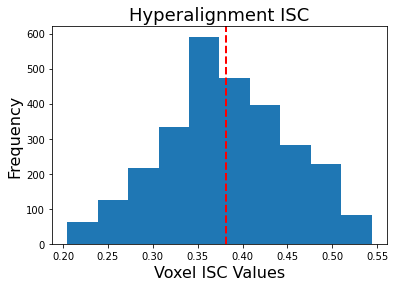

In [59]:
plt.hist(hyperalign['isc'].values())
plt.axvline(x=np.mean(list(hyperalign['isc'].values())), linestyle='--', color='red', linewidth=2)
plt.ylabel('Frequency', fontsize=16)
plt.xlabel('Voxel ISC Values', fontsize=16)
plt.title('Hyperalignment ISC', fontsize=18)

You can see that overall ISC across voxels is pretty high, mean=0.38. Remember that this value is biased because it is not cross-validated so that it is likely a little inflated.

We can also plot the average aligned voxel timecourse.

Text(0.5, 1.0, 'Hyperalignment Common Model')

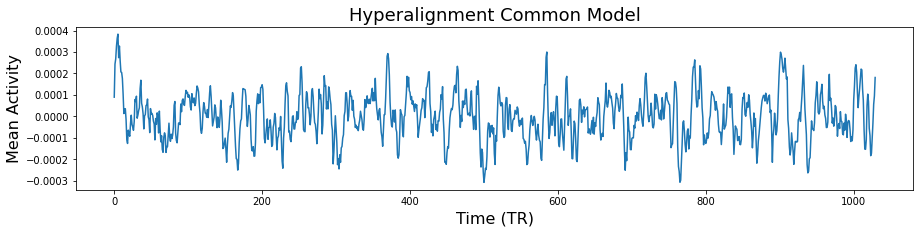

In [71]:
plt.figure(figsize=(15,3))
plt.plot(hyperalign['common_model'].mean(axis=1))
plt.ylabel('Mean Activity', fontsize=16)
plt.xlabel('Time (TR)', fontsize=16)
plt.title('Hyperalignment Common Model', fontsize=18)

In [64]:
hyperalign['transformed']

[nltools.data.brain_data.Brain_Data(data=(1030, 2786), Y=0, X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz, output_file=[]),
 nltools.data.brain_data.Brain_Data(data=(1030, 2786), Y=0, X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz, output_file=[]),
 nltools.data.brain_data.Brain_Data(data=(1030, 2786), Y=0, X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz, output_file=[]),
 nltools.data.brain_data.Brain_Data(data=(1030, 2786), Y=0, X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz, output_file=[]),
 nltools.data.brain_data.Brain_Data(data=(1030, 2786), Y=0, X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz, output_file=[]),
 nltools.data.brain_data.Brain_Data(data=(1030, 2786), Y=0, X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz, output_file=[]),
 nltools.data.brain_data.Brain_Data(data=(1030, 2786), Y=0, X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz, output_file=[]),
 nltools.data.brain_data.Brain_Data(data=(1030, 2786), Y=0, X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz, output_file=[]),


In [62]:
hyperalign.keys()

dict_keys(['transformed', 'common_model', 'transformation_matrix', 'disparity', 'scale', 'isc'])

## Shared Response Model (SRM)
Now let's try aligning using the shared response model. The shared response model allows for the possibility of aligning in a lower dimensional functional space. Here we provide an example of aligning to a 10 dimensional features space. Previous work has found that this can potentially improve generalizability of multivariate models trained on an ROI compared to using as many features as voxels. This feature is not yet implemented for procrustes transformation as dimensionality reduction would need to happen either before or after alignment. This one takes about a minute.

In [36]:
srm = align(list(all_data.values()), method='deterministic_srm', n_features=1000)

Text(0.5, 1.0, 'Shared Response Model ISC')

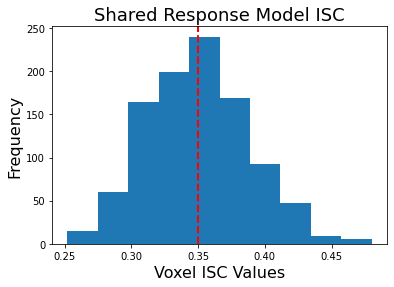

In [74]:
plt.hist(srm['isc'].values())
plt.axvline(x=np.mean(list(srm['isc'].values())), linestyle='--', color='red', linewidth=2)
plt.ylabel('Frequency', fontsize=16)
plt.xlabel('Voxel ISC Values', fontsize=16)
plt.title('Shared Response Model ISC', fontsize=18)

Text(0.5, 1.0, 'SRM Common Model')

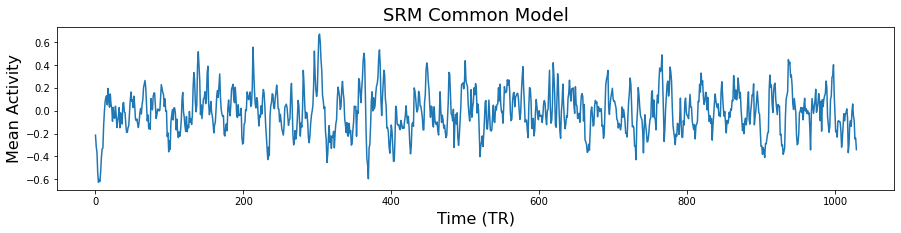

In [76]:
plt.figure(figsize=(15,3))
plt.plot(srm['common_model'].mean(axis=1))
plt.ylabel('Mean Activity', fontsize=16)
plt.xlabel('Time (TR)', fontsize=16)
plt.title('SRM Common Model', fontsize=18)

## Plot Transformed Data
To make it more clear what it is happening we plot the voxel by time matrices separately for each subject. It is clear that there is a consistent signal across voxels, but that the signal is distributed across 'different' voxels. The transformed data shows the voxels for each subject aligned to the common space.  This now permits inferences across the voxels.  As an example, we plot the matrices of the original compared to the aligned data across subjects.


## Transform aligned data back into original subject space
The transformation matrices can be used to project each subject's aligned data into the original subject specific voxel space. The procrustes method doesn't look identical as there are a few processing steps that occur within the algorithm that would need to be accounted for to fully recover the original data (e.g., centering, and scaling by norm).

# Align new subject to common model
We can also align a new subject to the common model without retraining the entire model.  Here we individually align subject 3 to the common space learned above.  We also backproject the transformed subject's data into the original subject voxel space.

In [20]:
align?

In [ ]:


#########################################################################
# Simulate Data
# -------------
#
# First, let's simulate some data to align. Here we will simulate 3 subjects
# with 100 data points. Each subject has signal in 30% of the voxels in the
# MPFC with noise.

import numpy as np
from nltools.mask import create_sphere
from nltools.data import Brain_Data
from nltools.stats import align
import matplotlib.pyplot as plt
from nilearn.plotting import plot_glass_brain

n_observations = 500
p = .3
sigma = 1
n_sub = 3

y = np.zeros(n_observations)
y[np.arange(75,150)] = 4
y[np.arange(200,250)] = 10
y[np.arange(300,475)] = 7

def simulate_data(n_observations, y, p, sigma, mask):
    ''' Simulate Brain Data

        Args:
            n_observations: (int) number of data points
            y: (array) one dimensional array of signal
            p: (float) probability of signal in voxels
            sigma: (float) amount of gaussian noise to add

        Returns:
            data: (list) of Brain_Data objects
    '''

    dat = Brain_Data(mask).apply_mask(mask)
    new_data = np.zeros((dat.shape()[0], n_observations))
    for i in np.where(dat.data==1)[0]:
        if np.random.randint(0,high=10) < p:
            new_data[i,:] = y
    noise = np.random.randn(new_data.shape[0],n_observations)*sigma
    dat.data = (new_data+noise).T
    return dat

mask = create_sphere([0, 45, 0], radius=8)
data = [simulate_data(n_observations, y, p, sigma, mask) for x in range(n_sub)]

plt.figure(figsize=(10,3))
plt.plot(y)
plt.title('Simulated Signal', fontsize=20)
plt.xlabel('Time', fontsize=18)
plt.ylabel('Signal', fontsize=18)
plot_glass_brain(data[0].mean().to_nifti())

#########################################################################
# Hyperalign Data
# ---------------
#
# We will now align voxels with the same signal across participants. We will
# start using hyperalignment with the procrustes transform. The align function
# takes a list of Brain_Data objects (or numpy matrices) and aligns voxels based
# on similar responses over time. The function outputs a dictionary with keys
# for a list of the transformed data, corresponding transofmration matrices and
# scaling terms.  In addition it returns the "common model" in which all
# subjects are projected. The disparity values correspond to the multivariate
# distance of the subject to the common space.

from nltools.stats import align

out = align(data, method='procrustes')

print(out.keys())


#########################################################################
# Plot Transformed Data
# ---------------------
#
# To make it more clear what it is happening we plot the voxel by time matrices
# separately for each subject. It is clear that there is a consistent signal
# across voxels, but that the signal is distributed across 'different' voxels.
# The transformed data shows the voxels for each subject aligned to the common
# space.  This now permits inferences across the voxels.  As an example, we
# plot the matrices of the original compared to the aligned data across subjects.

f,a = plt.subplots(nrows=2, ncols=3, figsize=(15,5), sharex=True, sharey=True)
[a[0,i].imshow(x.data.T, aspect='auto') for i,x in enumerate(data)]
[a[1,i].imshow(x.data.T, aspect='auto') for i,x in enumerate(out['transformed'])]
a[0,0].set_ylabel('Original Voxels', fontsize=16)
a[1,0].set_ylabel('Aligned Features', fontsize=16)
[a[1,x].set_xlabel('Time', fontsize=16) for x in range(3)]
[a[0,x].set_title('Subject %s' % str(x+1), fontsize=16) for x in range(3)]
plt.tight_layout()

f,a = plt.subplots(ncols=2, figsize=(15,5), sharex=True, sharey=True)
a[0].imshow(np.mean(np.array([x.data.T for x in data]), axis=0), aspect='auto')
a[1].imshow(np.mean(np.array([x.data.T for x in out['transformed']]), axis=0), aspect='auto')
a[0].set_ylabel('Voxels', fontsize=16)
[a[x].set_xlabel('Time', fontsize=16) for x in range(2)]
a[0].set_title('Average Voxel x Time Matrix of Original Data', fontsize=16)
a[1].set_title('Average Voxel x Time Matrix of Aligned Data', fontsize=16)


#########################################################################
# Transform aligned data back into original subject space
# -------------------------------------------------------
#
# The transformation matrices can be used to project each subject's aligned
# data into the original subject specific voxel space. The procrustes method
# doesn't look identical as there are a few processing steps that occur within
# the algorithm that would need to be accounted for to fully recover the original
# data (e.g., centering, and scaling by norm).

original_data = [np.dot(t.data, tm.T) for t,tm in zip(out['transformed'], out['transformation_matrix'])]

f,a = plt.subplots(nrows=3, ncols=3, figsize=(15,10), sharex=True, sharey=True)
[a[0, i].imshow(x.data.T, aspect='auto') for i, x in enumerate(data)]
[a[1, i].imshow(x.data.T, aspect='auto') for i, x in enumerate(out['transformed'])]
[a[2, i].imshow(x.T, aspect='auto') for i, x in enumerate(original_data)]
[a[i, 0].set_ylabel(x,fontsize=16) for i, x in enumerate(['Original Voxels','Aligned Features', 'Backprojected Voxels'])]
[a[2, x].set_xlabel('Time', fontsize=16) for x in range(3)]
[a[0, x].set_title('Subject %s' % str(x+1), fontsize=16) for x in range(3)]
plt.tight_layout()


#########################################################################
# Align new subject to common model
# ---------------------------------
#
# We can also align a new subject to the common model without retraining the
# entire model.  Here we individually align subject 3 to the common space
# learned above.  We also backproject the transformed subject's data into the
# original subject voxel space.

d3 = data[2]
d3_out = d3.align(out['common_model'], method='deterministic_srm')
bp = np.dot(d3_out['transformed'].data, d3_out['transformation_matrix'].T)

f,a = plt.subplots(ncols=3, figsize=(15,5), sharex=True, sharey=True)
a[0].imshow(d3.data.T, aspect='auto')
a[1].imshow(d3_out['transformed'].data.T, aspect='auto')
a[2].imshow(bp.T, aspect='auto')
[a[i].set_title(x,fontsize=18) for i, x in enumerate(['Original Data',' Transformed_Data', 'Backprojected Data'])]
[a[x].set_xlabel('Time', fontsize=16) for x in range(2)]
a[0].set_ylabel('Voxels', fontsize=16)
plt.tight_layout()

#########################################################################
# Align subjects in lower dimensional common space
# ------------------------------------------------
#
# The shared response model allows for the possibility of aligning in a lower
# dimensional functional space. Here we provide an example of aligning to a 10
# dimensional features space. Previous work has found that this can potentially
# improve generalizability of multivariate models trained on an ROI compared to
# using as many features as voxels. This feature is not yet implemented for
# procrustes transformation as dimensionality reduction would need to happen
# either before or after alignment.

n_features = 10
out = align(data, method='probabilistic_srm', n_features=n_features)

original_data = [np.dot(t.data,tm.T) for t,tm in zip(out['transformed'],out['transformation_matrix'])]

f,a = plt.subplots(nrows=3, ncols=3, figsize=(15,10), sharex=True, sharey=False)
[a[0, i].imshow(x.data.T, aspect='auto') for i, x in enumerate(data)]
[a[1, i].imshow(x.data.T, aspect='auto') for i, x in enumerate(out['transformed'])]
[a[2, i].imshow(x.T, aspect='auto') for i, x in enumerate(original_data)]
[a[i, 0].set_ylabel(x, fontsize=16) for i, x in enumerate(['Original Voxels','Aligned Features', 'Backprojected Voxels'])]
[a[2, x].set_xlabel('Time', fontsize=16) for x in range(3)]
[a[0, x].set_title('Subject %s' % str(x+1), fontsize=16) for x in range(3)]
plt.tight_layout()
